# Relax data science challenge

In [151]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

In [31]:
# Importing 'takehome_user_engagement' DataFrame
user_engagement=pd.read_csv('takehome_user_engagement.csv')
user_engagement.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [13]:
user_engagement.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
time_stamp    207917 non-null object
user_id       207917 non-null int64
visited       207917 non-null int64
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


In [52]:
# Convert time_stamp object column into datetime
user_engagement['time_stamp']=pd.to_datetime(user_engagement['time_stamp']).dt.date

In [35]:
# Check if each visit for a client is on different days
user_eng_g = user_engagement.groupby(['time_stamp','user_id'])['visited'].mean()
user_eng_g.shape
# The shape is the same as the initial dataframe, each visit for one client is on separate days 
# We can continue to use the initial dataframe user_engagement

(207917, 1)

In [92]:
# Defining "adopted" user (user who has logged into the product on 3 separate days in at least one seven-day period)
# New column 'duration'
user_engagement['duration']=0
# Find the duration between the first and the last connection by users
for x in range(1,207917):
    a=user_engagement.iloc[x,0]
    b=user_engagement.iloc[x-1,0]
    c=user_engagement.iloc[x,1]
    d=user_engagement.iloc[x-1,1]
    e=user_engagement.iloc[x-1,3]
    if c == d and e == '0':
        user_engagement.iloc[x,3]=a-b
        user_engagement.iloc[x,3]=user_engagement.iloc[x,3]/ np.timedelta64(1,'D') 
    elif c == d and e !='0':
        user_engagement.iloc[x,3]=a-b
        user_engagement.iloc[x,3]=user_engagement.iloc[x,3]/ np.timedelta64(1,'D')+e

In [94]:
user_engagement.head()

,time_stamp,user_id,visited,duration
0,2014-04-22,1,1,0
1,2013-11-15,2,1,0
2,2013-11-29,2,1,14
3,2013-12-09,2,1,24
4,2013-12-25,2,1,40


In [100]:
# New dataset with the duration between the first and the last connection by users
user_duration=user_engagement.groupby(['user_id'])['duration'].max().reset_index()
user_engagement=user_engagement.drop(['duration'],axis=1)

In [104]:
# Merge the new dataset with user_engagement for the 'duration' column
user_eng=user_engagement.merge(user_duration, on=['user_id','user_id'],how='left')
user_eng.head()

,time_stamp,user_id,visited,duration
0,2014-04-22,1,1,0.0
1,2013-11-15,2,1,136.0
2,2013-11-29,2,1,136.0
3,2013-12-09,2,1,136.0
4,2013-12-25,2,1,136.0


In [108]:
# Keep only the duration higher or egal to 7
user_eng=user_eng[user_eng.duration >= 7]
# New dataset with the number of visit by users during period egal or higher than 7
eng=user_eng.groupby(['user_id'])['visited'].count().reset_index()
eng.head()

,user_id,visited
0,2,14
1,10,284
2,20,7
3,33,18
4,42,342


In [109]:
# Keep only the number of visit higher or egal to 3
eng=eng[eng.visited>=3]
# New column 'adopted'
eng['adopted']=1
# Erase 'visited' column
eng=eng.drop(['visited'],axis=1)
eng.head()

,user_id,adopted
0,2,1
1,10,1
2,20,1
3,33,1
4,42,1


In [171]:
# takehome_users dataframe
users=pd.read_csv('takehome_users.csv',encoding = "ISO-8859-1")
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [172]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null object
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


In [173]:
# Merge of users and eng to create the variable to predict
users=users.merge(eng, left_on=['object_id'],right_on=['user_id'],how='left')
users=users.drop(['user_id'],axis=1)
# Transforme NaN value into 0 in 'adopted' column
users.adopted=users.adopted.replace(np.nan, 0)
users.adopted=users.adopted.astype(int)
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,1
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,0


In [174]:
# Cleaning data
# Erase not interesting columns for the prediction
users=users.drop(['name','object_id','email','invited_by_user_id','org_id'],axis=1)
# Fill NaN values in 'last_session_creation_time' with mean of the column
users.last_session_creation_time=users.last_session_creation_time.fillna(users.last_session_creation_time.mean(axis=0))
# New columns creation_source
users['personal_projects']=0
users.personal_projects[users.creation_source=='PERSONAL_PROJECTS']=1
users['guest_invite']=0
users.guest_invite[users.creation_source=='GUEST_INVITE']=1
users['org_invite']=0
users.org_invite[users.creation_source=='ORG_INVITE']=1
users['signup']=0
users.signup[users.creation_source=='SIGNUP']=1
users['signup_google_auth']=0
users.signup_google_auth[users.creation_source=='SIGNUP_GOOGLE_AUTH']=1
users.head()

C:\Users\Diane\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Diane\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Diane\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\Diane\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: Se

,creation_time,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,adopted,personal_projects,guest_invite,org_invite,signup,signup_google_auth
0,2014-04-22 03:53:30,GUEST_INVITE,1.398139e+09,1,0,0,0,1,0,0,0
1,2013-11-15 03:45:04,ORG_INVITE,1.396238e+09,0,0,1,0,0,1,0,0
2,2013-03-19 23:14:52,ORG_INVITE,1.363735e+09,0,0,0,0,0,1,0,0
3,2013-05-21 08:09:28,GUEST_INVITE,1.369210e+09,0,0,0,0,1,0,0,0
4,2013-01-17 10:14:20,GUEST_INVITE,1.358850e+09,0,0,0,0,1,0,0,0


In [177]:
# Transform 'last_session_creation_time' column into datetime
users['last_session_creation_time']=pd.to_datetime(users['last_session_creation_time'], unit='s')
users['creation_time']=pd.to_datetime(users['creation_time'])
# New column difference between last_session_creation_time and creation_time
users['duration_of_use']=users.last_session_creation_time-users.creation_time
users.duration_of_use=users.duration_of_use/ np.timedelta64(1,'D') 

In [179]:
users=users.drop(['last_session_creation_time','creation_time'],axis=1)
users.head()

,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,adopted,personal_projects,guest_invite,org_invite,signup,signup_google_auth,duration_of_use
0,GUEST_INVITE,1,0,0,0,1,0,0,0,0.0
1,ORG_INVITE,0,0,1,0,0,1,0,0,136.0
2,ORG_INVITE,0,0,0,0,0,1,0,0,0.0
3,GUEST_INVITE,0,0,0,0,1,0,0,0,1.0
4,GUEST_INVITE,0,0,0,0,1,0,0,0,5.0


In [180]:
users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 0 to 11999
Data columns (total 10 columns):
creation_source               12000 non-null object
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
adopted                       12000 non-null int32
personal_projects             12000 non-null int64
guest_invite                  12000 non-null int64
org_invite                    12000 non-null int64
signup                        12000 non-null int64
signup_google_auth            12000 non-null int64
duration_of_use               12000 non-null float64
dtypes: float64(1), int32(1), int64(7), object(1)
memory usage: 984.4+ KB


#### Data Visualisation

Number of adopted by creation_source

                    adopted
creation_source            
GUEST_INVITE            500
ORG_INVITE              782
PERSONAL_PROJECTS       230
SIGNUP                  418
SIGNUP_GOOGLE_AUTH      310


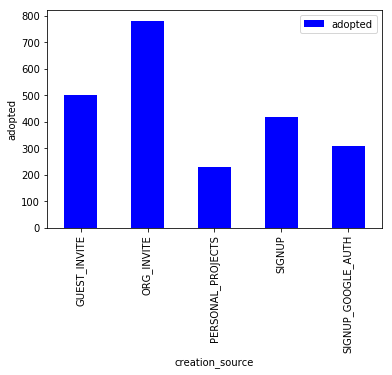

In [130]:
users_adopted=users.groupby(['creation_source'])[['adopted']].sum()
print(users_adopted)
users_adopted.plot(y='adopted',kind='bar',color='b')
plt.ylabel('adopted')
plt.show()

In [186]:
# Remove 'creation_source' column
users=users.drop(['creation_source'],axis=1)

Number of adopted who opted or not to the mailing list

                          adopted
opted_in_to_mailing_list         
0                            1663
1                             577


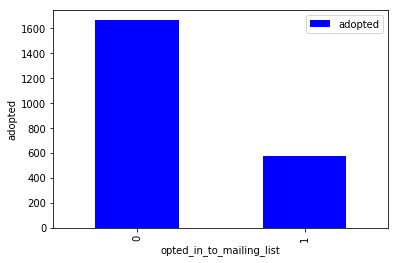

In [131]:
users_adopted_=users.groupby(['opted_in_to_mailing_list'])[['adopted']].sum()
print(users_adopted_)
users_adopted_.plot(y='adopted',kind='bar',color='b')
plt.ylabel('adopted')
plt.show()

Number of adopted or not adopted who opted to mailing list 

         opted_in_to_mailing_list
adopted                          
0                            2417
1                             577


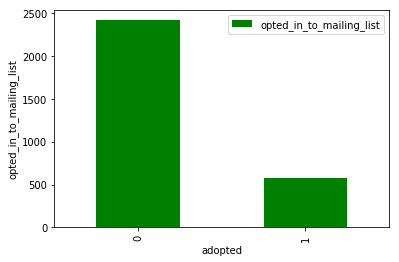

In [143]:
users_adopted_=users.groupby(['adopted'])[['opted_in_to_mailing_list']].sum()
print(users_adopted_)
users_adopted_.plot(y='opted_in_to_mailing_list',kind='bar',color='g')
plt.ylabel('opted_in_to_mailing_list')
plt.show()

Number of adopted who are or not on the regular marketing email drip

                            adopted
enabled_for_marketing_drip         
0                              1893
1                               347


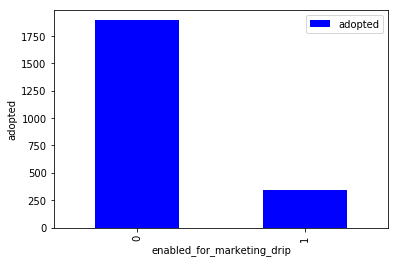

In [132]:
users_adopted_=users.groupby(['enabled_for_marketing_drip'])[['adopted']].sum()
print(users_adopted_)
users_adopted_.plot(y='adopted',kind='bar',color='b')
plt.ylabel('adopted')
plt.show()

Number of adopted or not adopted who are on the regular marketing email drip

         enabled_for_marketing_drip
adopted                            
0                              1445
1                               347


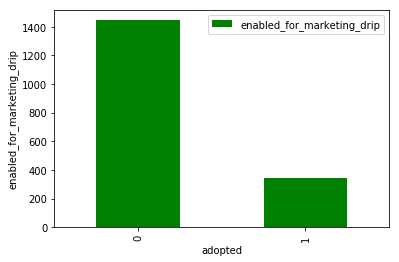

In [144]:
users_adopted_=users.groupby(['adopted'])[['enabled_for_marketing_drip']].sum()
print(users_adopted_)
users_adopted_.plot(y='enabled_for_marketing_drip',kind='bar',color='g')
plt.ylabel('enabled_for_marketing_drip')
plt.show()

Last session creation time by adopted or not adopted

         duration_of_use
adopted                 
0              23.088660
1             227.907143


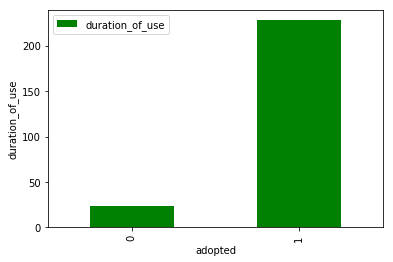

In [181]:
users_adopted_=users.groupby(['adopted'])[['duration_of_use']].mean()
print(users_adopted_)
users_adopted_.plot(y='duration_of_use',kind='bar',color='g')
plt.ylabel('duration_of_use')
plt.show()

We observe differences in the adopted or between the adopted and the not adopted users depending on creation_source, opted_in_to_mailing_list, enabled_for_marketing_drip. This seems to have a strong relation between the duration of use and the adopted user.

#### Linear regression statistic

In [187]:
results = smf.ols('adopted ~ duration_of_use + opted_in_to_mailing_list + enabled_for_marketing_drip + personal_projects + guest_invite + org_invite + signup', data=users).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                adopted   R-squared:                       0.241
Model:                            OLS   Adj. R-squared:                  0.241
Method:                 Least Squares   F-statistic:                     544.7
Date:                Tue, 29 Oct 2019   Prob (F-statistic):               0.00
Time:                        14:43:37   Log-Likelihood:                -4060.5
No. Observations:               12000   AIC:                             8137.
Df Residuals:                   11992   BIC:                             8196.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

We can see that the features opted_in_to_mailing_list, guest_invite, signup and enabled_for_marketing_drip have a very high p_value. They are not good predictors for the future user adoption. The other features have a significant p_value (<0.001). The duration_of_use has positive coefficient, the chances for a futur user adoption increase when the value of this feature also increases. The other features have negative coefficients, the chances for a futur user adoption increase when the value of these features decrease. If the duration_of_use increases by one unit (1 day), the chances for a futur user adoption increase by 0.0011. If the personal_projects decrease by one unit, the chances for a futur user adoption increase by 0.13. And if the org_invite decrease by one unit, the chances for a futur user adoption increase by 0.037.

#### Machine Learning algorithm

In [188]:
# Get X and y
X = users.drop(['adopted','signup'],axis=1)
y = users.adopted
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=21)

In [189]:
# Random Forest Model: tune hyperparameter
param_grid={'max_depth':np.arange(1,10)}
regr=RandomForestRegressor(random_state=21)
regr_cv=GridSearchCV(regr,param_grid,cv=5)
regr_cv.fit(X_train,y_train)
print('Best parameter:',regr_cv.best_params_)
print('Best score:',regr_cv.best_score_)

C:\Users\Diane\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Diane\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Diane\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Diane\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Diane\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: F

C:\Users\Diane\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Diane\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Diane\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Diane\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Diane\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: F

Best parameter: {'max_depth': 9}
Best score: 0.578765219872847


C:\Users\Diane\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Diane\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Diane\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [190]:
# Random Forest Model: model
regr=RandomForestRegressor(max_depth=9,random_state=21)
regr.fit(X_train , y_train)
print('R² Score train data =',regr.score(X_train,y_train))
print('R² Score test data =',regr.score(X_test,y_test))

R² Score train data = 0.6449398377427981
R² Score test data = 0.6076022053667878


C:\Users\Diane\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [191]:
# Feature importance of the model
feature_importances = pd.DataFrame(regr.feature_importances_,index = X_train.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
feature_importances

,importance
duration_of_use,0.851498
personal_projects,0.105013
signup_google_auth,0.022987
org_invite,0.007105
opted_in_to_mailing_list,0.005479
guest_invite,0.004631
enabled_for_marketing_drip,0.003286


To predict the chances for future users adoption, we choose Random Forest Regressor as machine learning algorithm. It is easy to tune its hyperparameters and it is good for the small dataset with only few features. The accuracy of the train data is 0.65 and the accuracy of the test data is 0.61. Even if the accuracy is not very high, the model is pretty good because there is not overfitting. But to improve the model, we would need more features which can predict the future user adoption. 

The most important features of the model is: duration_of_use and personal_projects. We saw with the linear regression statistics that the coefficient of duration_of_use is positive, the users have more chances to become adopted if they have a high duration of the service. This is an essential criterion. And the coefficient of personnal_projects is negative, the users have low chances to become adopted if they are invited to join another user's personal workspace. 

Based on these results, it is possible to advise the company to propose an offer that could make users who are invited to join another user's personal workspace, want to continue using the service in the longer term. Perhaps it would be interesting for all users to offer them interesting offers in the long term, to build their loyalty to the service. It could be interesting to work on the platform to make it easier to use, more attractive for potential users, especially for those who have a short glimpse of it and who will be more interested in using it in the long term. 